In [1]:
import os
import sys
import torch
import pytorch3d
import matplotlib.pyplot as plt
import numpy as np

# libraries for reading data from files
from scipy.io import loadmat
from PIL import Image
import pickle

In [2]:
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
)

import sys
import os
sys.path.append(os.path.abspath(''))
sys.path.append("../")

In [5]:
# UV_processed.mat
!wget https://dl.fbaipublicfiles.com/densepose/densepose_uv_data.tar.gz
!tar xvf densepose_uv_data.tar.gz -C ../data/DensePose
!rm densepose_uv_data.tar.gz

--2024-03-18 15:58:53--  https://raw.githubusercontent.com/facebookresearch/DensePose/master/DensePoseData/demo_data/texture_from_SURREAL.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
Unable to establish SSL connection.
--2024-03-18 15:59:56--  https://dl.fbaipublicfiles.com/densepose/densepose_uv_data.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.222.236.115, 52.222.236.65, 52.222.236.117, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22743040 (22M) [application/x-tar]
Saving to: ‘densepose_uv_data.tar.gz’

densepose_uv_data.t 100%[===================>]  21.69M  2.32MB/s    in 36s     

2024-03-18 16:00:36 (622 KB/s) - ‘densepose_uv_data.tar.gz’ saved [22743040/22743040]

x

In [6]:
# Texture image
!wget -P ../data/DensePose https://raw.githubusercontent.com/facebookresearch/DensePose/master/DensePoseData/demo_data/texture_from_SURREAL.png

--2024-03-18 16:00:53--  https://raw.githubusercontent.com/facebookresearch/DensePose/master/DensePoseData/demo_data/texture_from_SURREAL.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 831242 (812K) [image/png]
Saving to: ‘../data/DensePose/texture_from_SURREAL.png’

texture_from_SURREA 100%[===================>] 811.76K   256KB/s    in 3.2s    

2024-03-18 16:00:59 (256 KB/s) - ‘../data/DensePose/texture_from_SURREAL.png’ saved [831242/831242]



In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

print(f"Device is {device}")

Device is cpu


In [4]:
DATA_DIR = "../data"
data_filename = os.path.join(DATA_DIR, "DensePose/UV_Processed.mat")
tex_filename = os.path.join(DATA_DIR, "DensePose/texture_from_SURREAL.png")
verts_filename = os.path.join(DATA_DIR, "DensePose/smpl_model.pkl")

In [5]:
with open(verts_filename, "rb") as f:
    data = pickle.load(f, encoding="latin1")
    v_template = torch.tensor(data["v_template"], dtype=torch.float32).to(device)

ALP_UV = loadmat(data_filename)

with Image.open(tex_filename) as img:
    np_image = np.asarray(img.convert("RGB")).astype(np.float32)

tex = torch.from_numpy(np_image / 255.)[None].to(device)

/var/folders/rd/pptsn4g94yn355rms_txgp680000gn/T/ipykernel_78817/3954589126.py:2: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(f, encoding="latin1")


In [6]:
verts = torch.from_numpy((ALP_UV["All_vertices"]).astype(int)).squeeze().to(device)
U = torch.from_numpy(ALP_UV["All_U_norm"]).to(device, dtype=torch.float32)
V = torch.from_numpy(ALP_UV["All_V_norm"]).to(device, dtype=torch.float32)
faces = torch.from_numpy((ALP_UV["All_Faces"] - 1).astype(int)).to(device)
face_indices = torch.Tensor(ALP_UV["All_FaceIndices"]).squeeze().to(device)

In [7]:
def show_image(img, title="", figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(img.squeeze().cpu().numpy())
    plt.title(title)
    plt.axis("off")

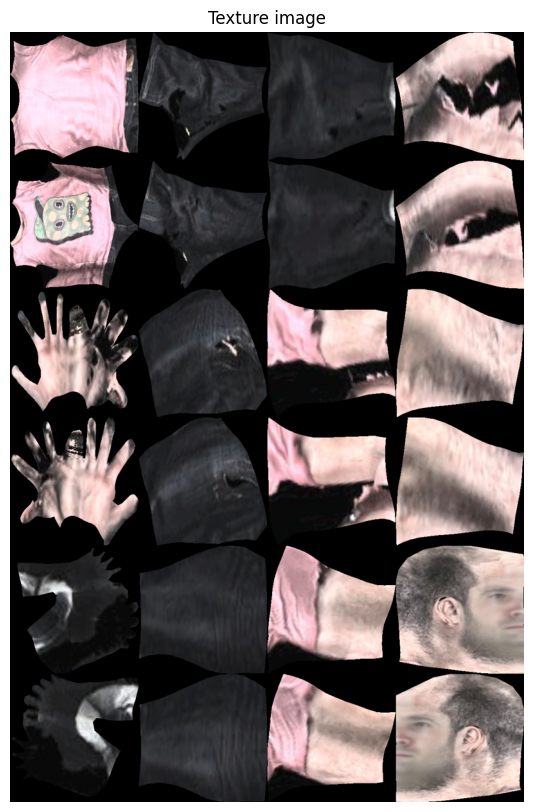

In [8]:
show_image(tex, "Texture image")

In [9]:
offset_per_part = {}
already_offset = set()
cols, rows = 4, 6

for i, u in enumerate(np.linspace(0, 1, cols, endpoint=False)):
    for j, v in enumerate(np.linspace(0, 1, rows, endpoint=False)):
        part_id = i * rows + j + 1  # part_id is 1-indexed
        offset_per_part[part_id] = (u, v)

U_norm = U.clone()
V_norm = V.clone()

for i in range(len(faces)):
    face_vertex_idxs = faces[i]
    part = face_indices[i]
    u_offset, v_offset = offset_per_part[int(part.item())]

    for vertex_idx in face_vertex_idxs:
        if vertex_idx.item() not in already_offset:
            U_norm[vertex_idx] = U[vertex_idx] * (1 / cols) + u_offset
            V_norm[vertex_idx] = (1 - V[vertex_idx]) * (1 / rows) + v_offset
            already_offset.add(vertex_idx.item())

V_norm = 1 - V_norm

In [10]:
verts_uv = torch.cat([U_norm[None], V_norm[None]], dim=2)
v_template_extended = v_template[verts - 1][None]

In [11]:
texture = TexturesUV(maps=tex, faces_uvs=faces[None], verts_uvs=verts_uv)
mesh = Meshes(v_template_extended, faces[None], texture)

In [12]:
R, T = look_at_view_transform(2.7, 0, 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=[[0.0, 0.0, 2.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights),
)

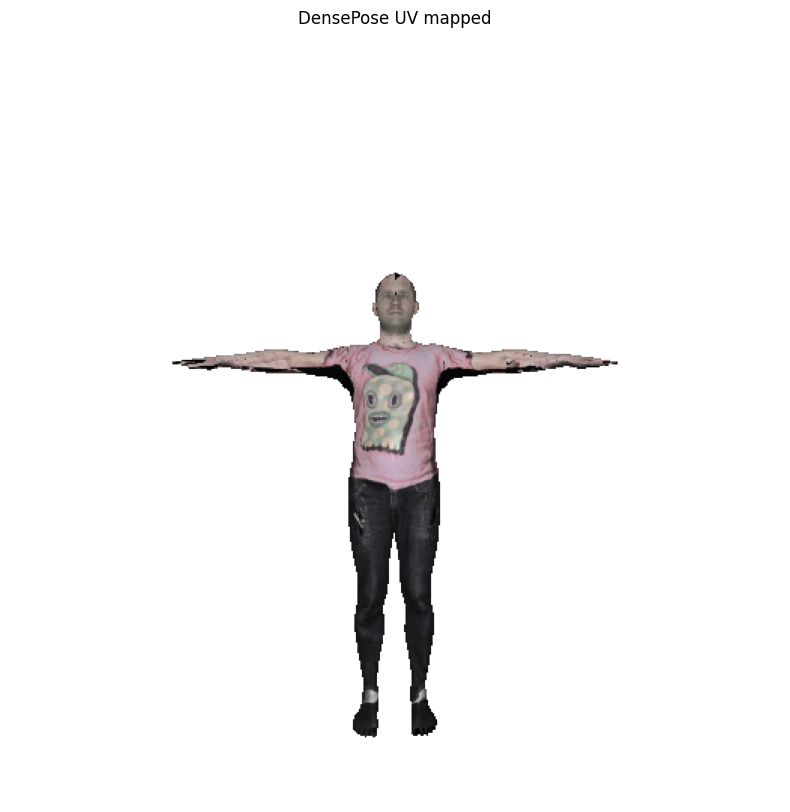

In [15]:
images = renderer(mesh)
show_image(images[0, ..., :3], "DensePose UV mapped")

In [16]:
R, T = look_at_view_transform(2.7, 10, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)
images = renderer(mesh, cameras=cameras, lights=lights)

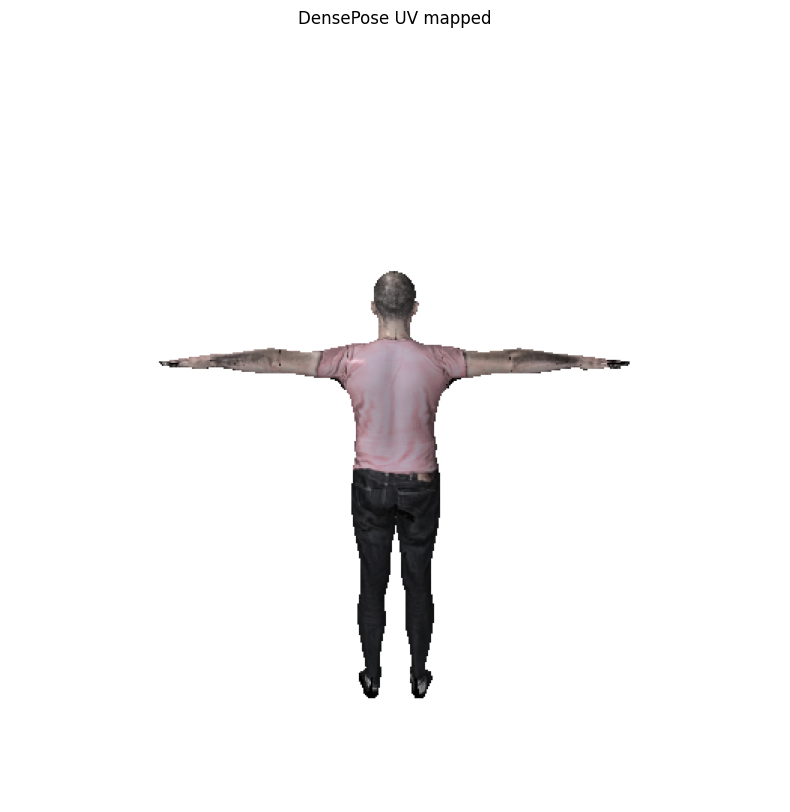

In [17]:
show_image(images[0, ..., :3], "DensePose UV mapped")